In [2]:
from pcurve import PrincipalCurve
import numpy as np
from matplotlib import pyplot as plt

In [46]:
def project_to_curve(x, s, stretch = 2):
    nseg = s.shape[0] - 1
    npts = x.shape[0]
    ncols = x.shape[1]
    print('nseg', nseg, 'ncols', ncols)
    print('x', x.shape, 's', s.shape)

    # argument checks
    if s.shape[1] != ncols:
        raise "'x' and 's' must have an equal number of columns"

    if s.shape[0] < 2:
        raise "'s' must contain at least two rows."

    if x.shape[0] == 0:
        raise "'x' must contain at least one row."

    if stretch < 0:
        raise "Argument 'stretch' should be larger than or equal to 0"


    # perform stretch on end points of s
    # only perform stretch if s contains at least two rows
    if stretch > 0 and s.shape[0] >= 2:
        s = s.copy()
        n = s.shape[0]
        diff1 = s[0, :] - s[1, :]
        diff2 = s[n - 1, :] - s[n - 2, :]
        s[0, :] = s[0, :] + stretch * diff1
        s[n - 1, :] = s[n - 1, :] + stretch * diff2


    # precompute distances between successive points in the curve
    # and the length of each segment
    diff = np.zeros((nseg, ncols))
    length = np.zeros(nseg)

    # preallocate variables
    i, j, k, l, m = 0, 0, 0, 0, 0
    u, v, w = 0., 0., 0.

    for i in range(nseg):
        # OPTIMISATION: compute length manually
        #   diff(i, _) = s(i + 1, _) - s(i, _)
        #   length[i] = sum(pow(diff(i, _), 2))
        w = 0
        for k in range(ncols):
            v = s[i + 1, k] - s[i, k]
            # diff[k * nseg + i] = v
            diff[i, k] = v
            w += v * v
        length[i] = w
        # END OPTIMISATION


    # allocate output data structures
    new_s = np.zeros((npts, ncols))    # projections of x onto s
    pseudotime = np.zeros(npts)           # distance from start of the curve
    dist_ind = np.zeros(npts)         # distances between x and new_s

    # pre-allocate intermediate vectors
    n_test = np.zeros(ncols)
    n = np.zeros(ncols)
    p = np.zeros(ncols)

    # iterate over points in x
    for i in range(npts):
        # store information on the closest segment
        bestlam = -1
        bestdi = np.iinfo(np.int64).max

        # copy current point to p
        for k in range(ncols):
            p[k] = x[i, k]

        # iterate over the segments
        for j in range(nseg):
            # project p orthogonally onto the segment
            # OPTIMISATION: do not allocate diff1 and diff2 compute t manually
            #   NumericVector diff1 = s(j + 1, _) - s(j, _)
            #   NumericVector diff2 = p - s(j, _)
            #   double t = sum(diff1 * diff2) / length(j)
            v = 0
            for k in range(ncols):
               v += diff[j, k] * (p[k] - s[j, k])

            v /= length[j]
            # END OPTIMISATION
            if v < 0:
                v = 0.0
            if v > 1:
                v = 1.0

            # calculate position of projection and the distance
            # OPTIMISATION: compute di and n_test manually
            #   NumericVector n_test = s(j, _) + t * diff(j, _)
            #   double di = sum(pow(n_test - p, 2.0))
            w = 0
            for k in range(ncols):
                u = s[j, k] + v * diff[j, k]
                n_test[k] = u
                w += (u - p[k]) * (u - p[k])

            # END OPTIMISATION

            # if this is better than what was found earlier, store it
            if w < bestdi:
                bestdi = w
                bestlam = j + .1 + .9 * v
                for k in range(ncols):
                   n[k] = n_test[k]

        # save the best projection to the output data structures
        pseudotime[i] = bestlam
        dist_ind[i] = bestdi
        for k in range(ncols):
            # new_s[k * npts + i] = n[k]
            new_s[i, k] = n[k]


    # get ordering from old pseudotime
    new_ord = pseudotime.argsort()

    # calculate total dist
    dist = dist_ind.sum()

    # recalculate pseudotime for new_s
    pseudotime[new_ord[0]] = 0

    for i in range(1, new_ord.shape[0]):
        l = new_ord[i - 1]
        m = new_ord[i]

        # OPTIMISATION: compute pseudotime[o1] manually
        #   NumericVector p1 = new_s(o1, _)
        #   NumericVector p0 = new_s(o0, _)
        #   pseudotime[o1] = pseudotime[o0] + sqrt(sum(pow(p1 - p0, 2.0)))
        w = 0
        for k in range(ncols):
            v = new_s[m, k] - new_s[l, k]
            w += v * v
        pseudotime[m] = pseudotime[l] + np.sqrt(w)
    # END OPTIMISATION

    return PrincipalCurve.from_params(pseudotime, new_s, order=ord), dist_ind, dist

(100, 2) (3, 2)
nseg 2 ncols 2
x (100, 2) s (3, 2)
1.0


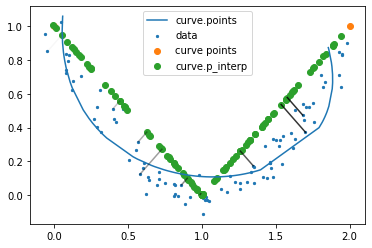

In [51]:
t = np.random.uniform(-1, 1, 100)
x = np.stack([t, t**2], axis=1) + np.random.normal(0, 0.05, (100, 2))
x[:, 0] += 1
plt.scatter(x[:, 0], x[:, 1], s=5, label='data')
s = np.array([[0, 1, 2], [1, 0, 1]]).T
print(x.shape, s.shape)
plt.scatter(s[:, 0], s[:, 1], label='curve points')
curve = PrincipalCurve(k=3)

curve.fit(x, p=s, max_iter=1)
plt.plot(curve.points[:, 0], curve.points[:, 1], label='curve.points')
pseudotime_interp, p_interp, d = curve.project_to_curve(x, s)
curve, dist_ind, dist = project_to_curve(x, s)
pseudotime_interp = curve.pseudotimes_interp
pseudotime_min = pseudotime_interp.min()
pseudotime_interp = (pseudotime_interp - pseudotime_min) / (pseudotime_interp.max() - pseudotime_min)
print(pseudotime_interp.max())
p_interp = curve.points_interp
# plt.scatter(p_interp[:, 0], p_interp[:, 1], label='p_interp')
# plt.plot(curve.points[:, 0], curve.points[:, 1])

plt.scatter(curve.points_interp[:, 0], curve.points_interp[:, 1], label='curve.p_interp')

for i in range(10):
    path_from = (x[i][0], p_interp[i][0])
    path_to = (x[i][1], p_interp[i][1])
    plt.plot(path_from, path_to, c='black', alpha=pseudotime_interp[i])

plt.legend()


(100, 2) (3, 2)


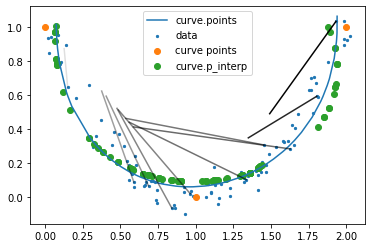

In [26]:
t = np.random.uniform(-1, 1, 100)
x = np.stack([t, t**2], axis=1) + np.random.normal(0, 0.05, (100, 2))
x[:, 0] += 1
plt.scatter(x[:, 0], x[:, 1], s=5, label='data')
s = np.array([[0, 1, 2], [1, 0, 1]]).T
print(x.shape, s.shape)
plt.scatter(s[:, 0], s[:, 1], label='curve points')
curve = PrincipalCurve(k=3)

curve.fit(x, p=s, max_iter=2)
plt.scatter(curve.points_interp[:, 0], curve.points_interp[:, 1], label='curve.p_interp')
plt.plot(curve.points[:, 0], curve.points[:, 1], label='curve.points')
s, p_interp, d = curve.project_to_curve(x, s)
# plt.scatter(p_interp[:, 0], p_interp[:, 1], label='p_interp')
# plt.plot(curve.points[:, 0], curve.points[:, 1])
for i in range(10):
    path_from = (x[i][0], p_interp[i][0])
    path_to = (x[i][1], p_interp[i][1])
    plt.plot(path_from, path_to, c='black', alpha=s[i])

plt.legend()

